<a href="https://colab.research.google.com/github/bicalabs/locallearning/blob/master/snn_hebian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

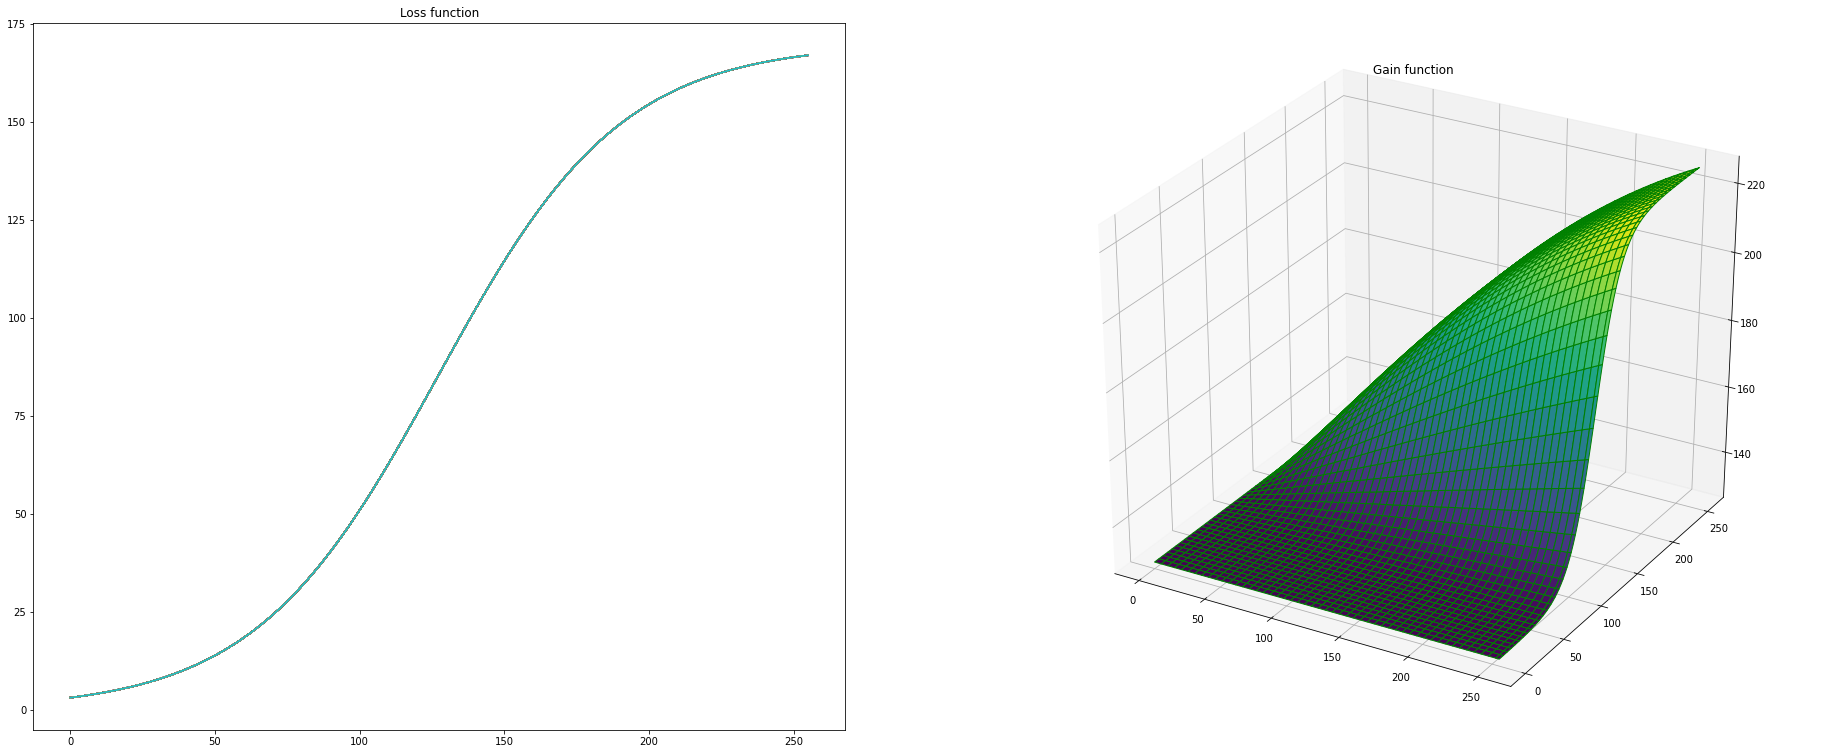

In [140]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

def loss(input, decay = 1.5, skew = 4.0):
  # output = input / (1 + 2 * tf.cos((input - 127.) / 255. * math.pi))
  # output = tf.math.log(input) / math.log(255) * 255. / decay
  output = tf.sigmoid((input - 127) / 127 * skew) * 255 / decay
  return output

def gain(weights, output):
  data = tf.sigmoid(weights * tf.sigmoid((output - 127) / 16) / 127) * 256
  return data

fig = plt.figure(figsize = (32, 13))

x = np.outer(np.linspace(0, 255, 100), np.ones(100))
y = loss(x)

ax = fig.add_subplot(1, 2, 1)
ax.plot(x, y)
ax.set_title('Loss function')

y = x.copy().T
z = gain(x, y)
  
# syntax for 3-D plotting
ax = fig.add_subplot(1, 2, 2, projection ='3d')
  
# syntax for plotting
ax.plot_surface(x, y, z, cmap ='viridis', edgecolor ='green')
ax.set_title('Gain function')

plt.show()

In [145]:
import tensorflow as tf
import math


class SpikingLayer(tf.Module):
  def __init__(self, dim = 256, threshold = tf.constant(10.), decay = 1.2, skew = 4., **kwargs):
    super().__init__(**kwargs)

    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    self.skew = skew
    # Setting dimenstionality
    self.dim = dim

    # Initialize layers
    self.weights = tf.Variable(tf.random.uniform((dim, dim), minval = 0., maxval = 255.))
    
  def __call__(self, input, train: bool):
    input = tf.reshape(input, [1, -1])
    output = tf.clip_by_value(input @ self.weights / (255 * 255.) - self.threshold, 0., 255.)
    if train:
      output_ext = output + tf.constant(0.0, shape = (self.dim, self.dim))
      map = tf.clip_by_value(output_ext, 0, 1)
      # loss = tf.sigmoid((self.weights - 127) / 127 * self.skew) * 255 / self.decay
      # gain = (tf.sigmoid(self.weights * map) - 0.5) * 255.
      self.weights = loss(self.weights, self.decay, self.skew) * (1 - map) + gain(self.weights, output_ext) * map
    return output


class HebianNet(tf.Module):
  def __init__(self, dim = 256, layer_count = 10, threshold = tf.constant(10.), decay = 1.2, skew = 4., seed = 2613546, **kwargs):
    super().__init__(**kwargs)

    # Initialize seed for better determinism
    self.seed = seed
    tf.random.set_seed(seed)
    
    # Setting action potential threshold
    self.threshold = threshold
    # Setting dweights coefficient decay rate
    self.decay = decay
    self.skew = skew
    # Setting dimenstionality
    self.dim = dim

    self.layers = []
    self.layer_count = layer_count
    for layer_no in range(0, layer_count):
      self.layers.append(SpikingLayer(dim, threshold, decay, skew, **kwargs))

  def __call__(self, input, train: bool):
    input = tf.cast(input, tf.float32)
    for layer in self.layers:
      output = layer(input, train)
      input = output
    return output


tf.Tensor(
[[46.91208  46.91208  46.91208  ... 46.91208  46.91208  46.912052]
 [46.912052 46.91208  46.91208  ... 46.91208  46.91208  46.91208 ]
 [46.91208  46.912052 46.91208  ... 46.91208  46.912052 46.91208 ]
 ...
 [46.91208  46.91208  46.91208  ... 46.91208  46.91208  46.91208 ]
 [46.91208  46.91208  46.91208  ... 46.91208  46.91208  46.91208 ]
 [46.91208  46.91208  46.91208  ... 46.91208  46.91208  46.91208 ]], shape=(784, 784), dtype=float32)


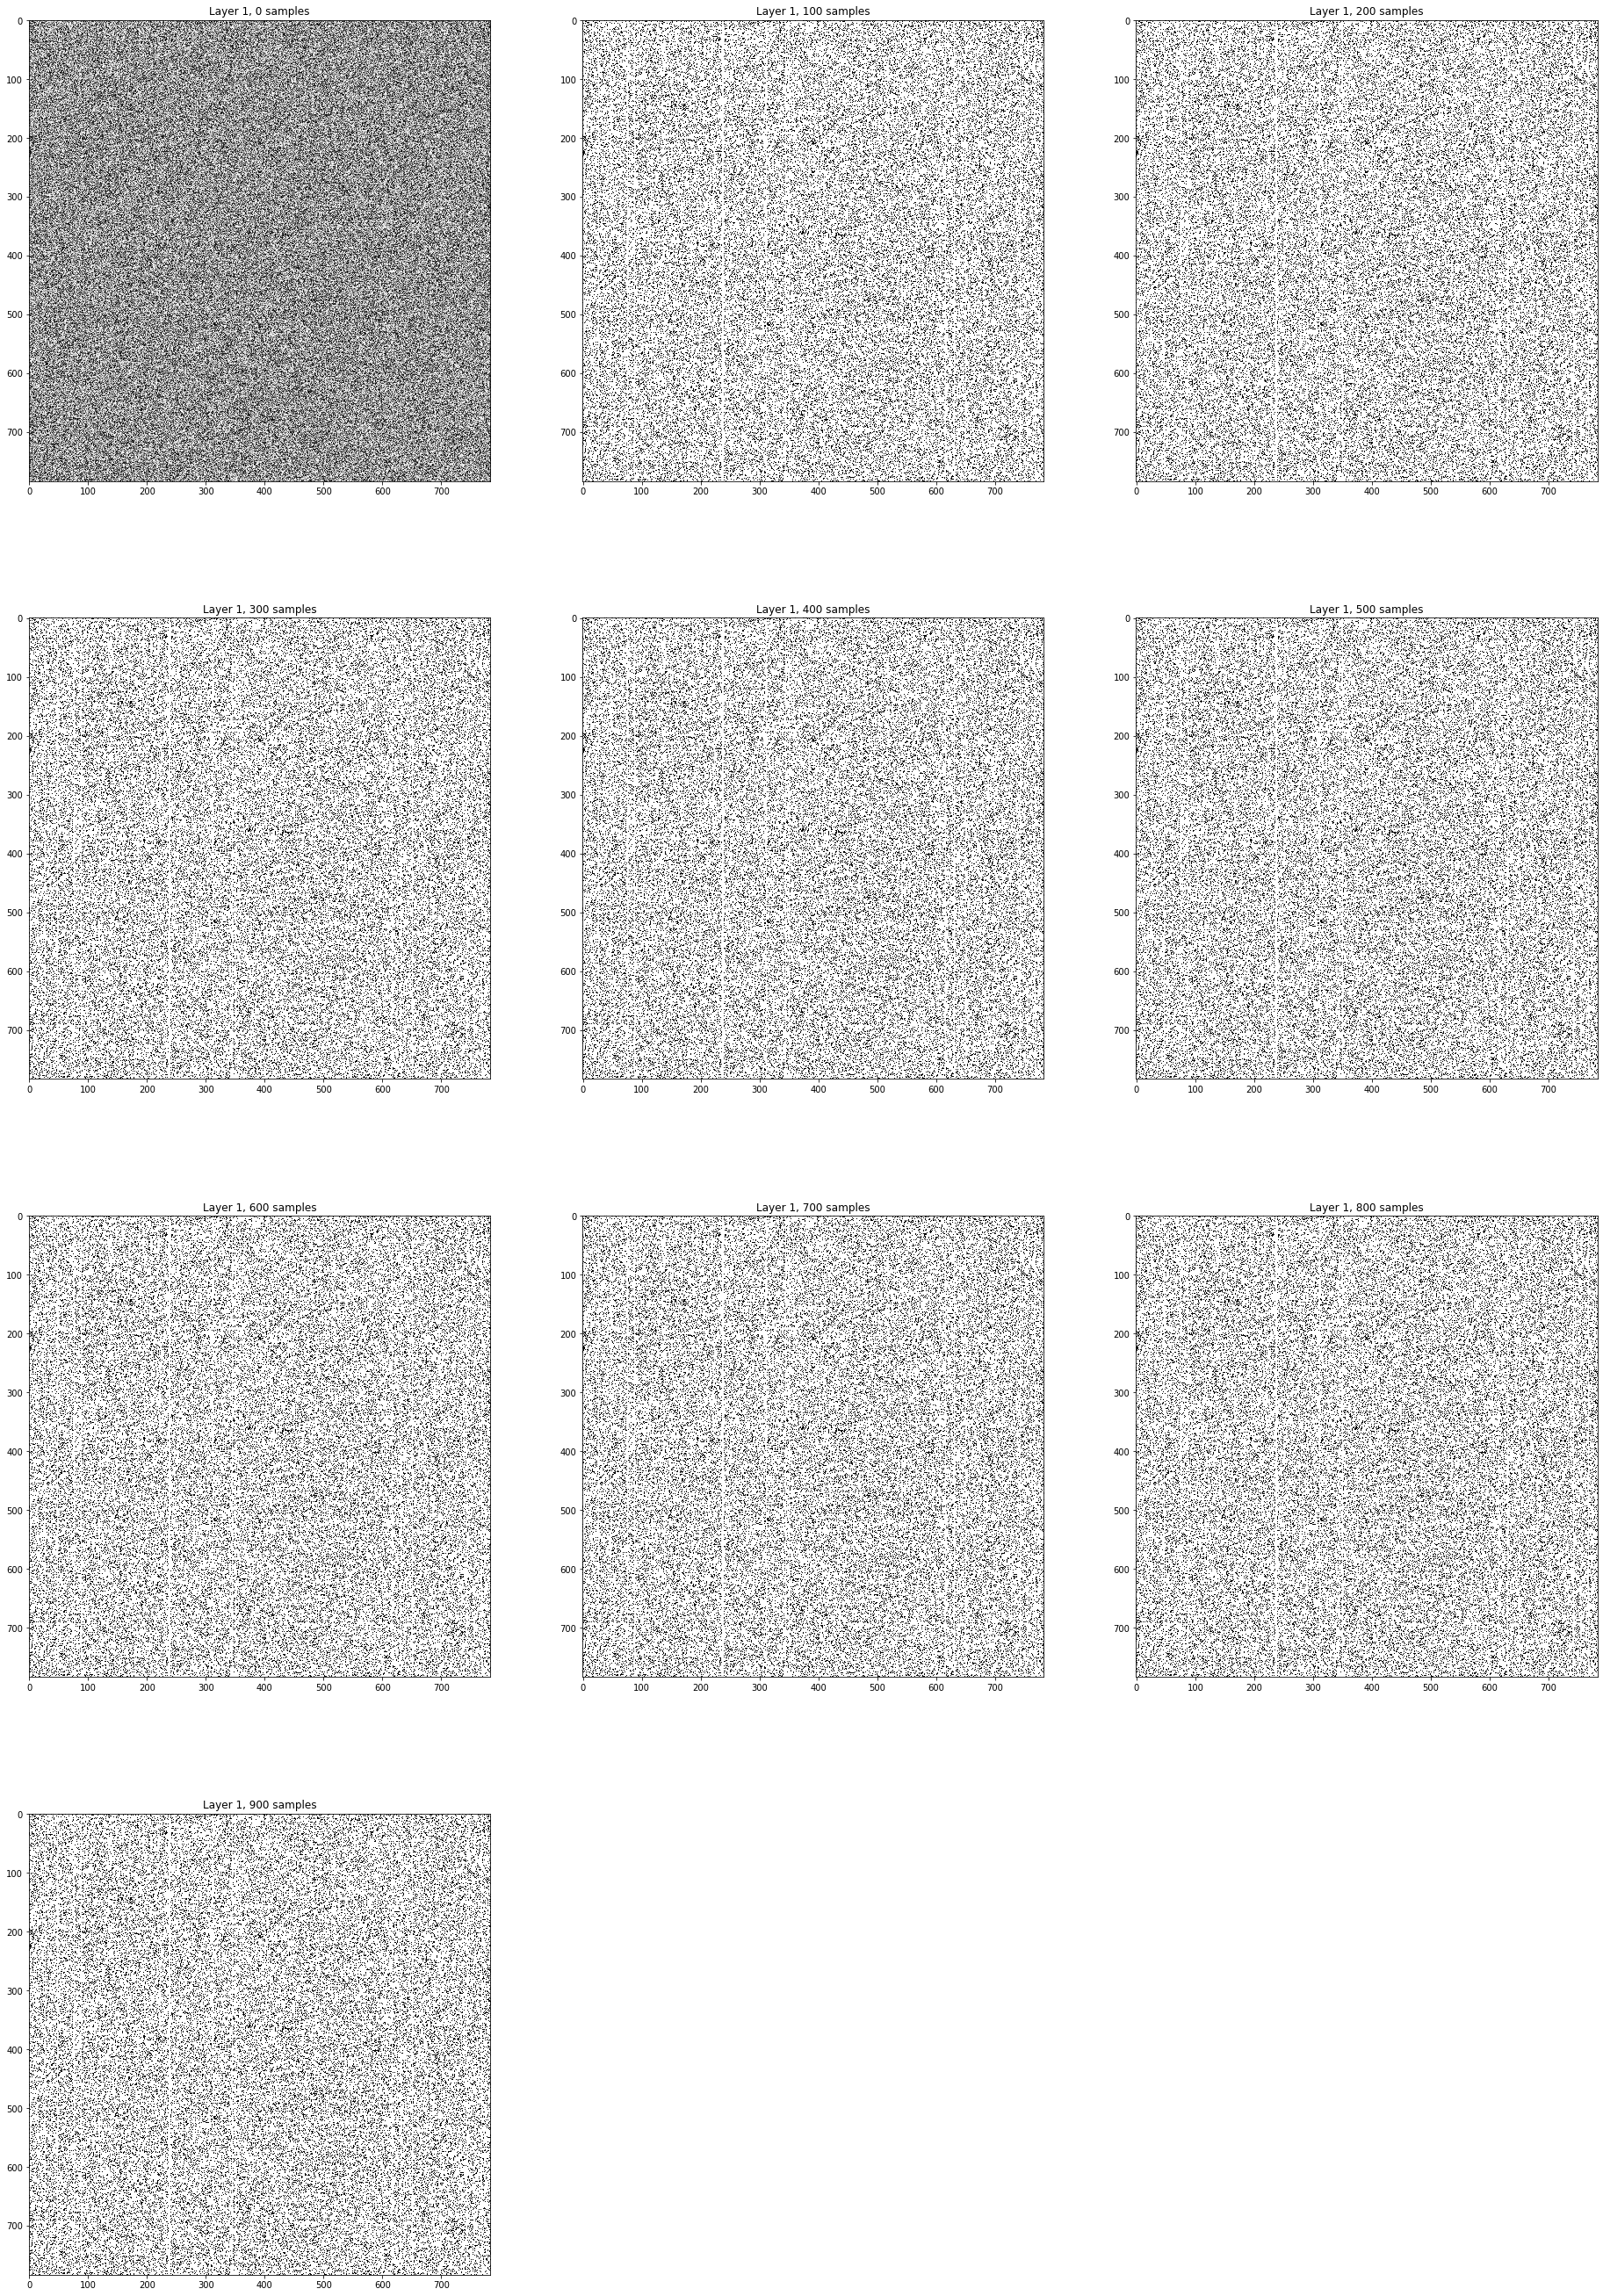

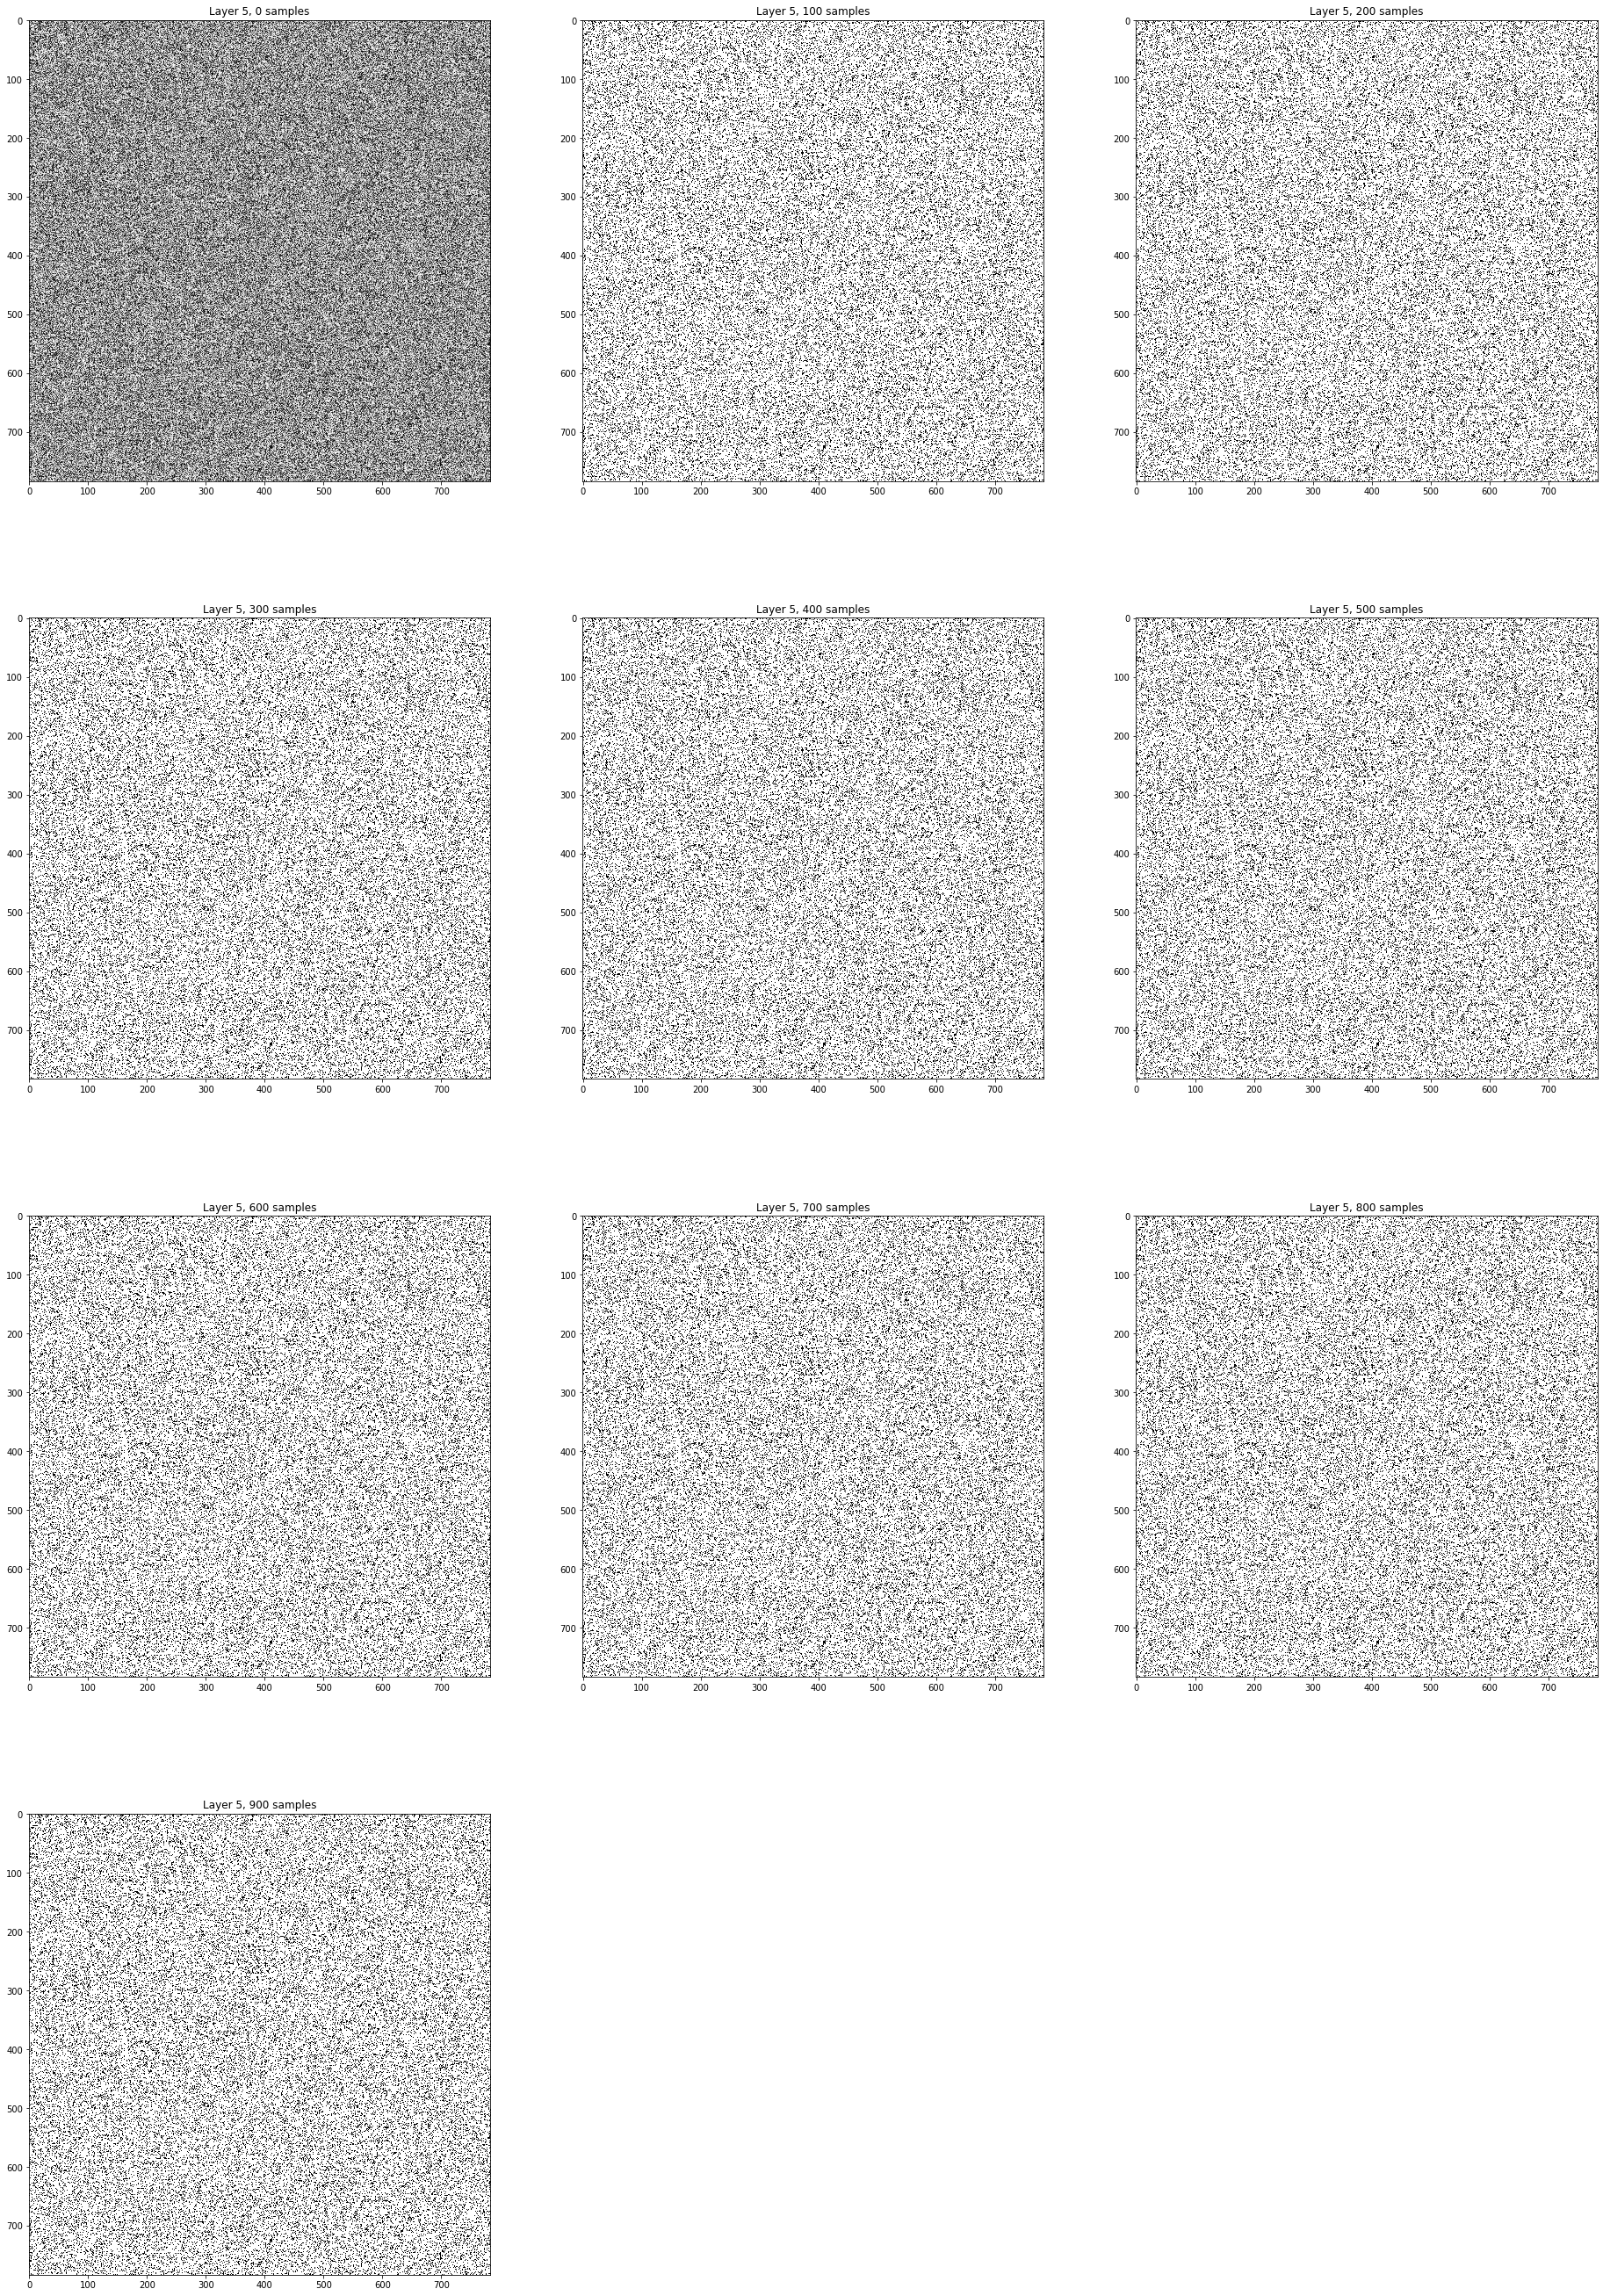

In [154]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
data = tf.reshape(x_train, (-1, 28 * 28))
data = tf.random.shuffle(data)

snn = HebianNet(dim = 28 * 28, layer_count = 5, threshold = 65., decay = 1.2, skew = 2.)

fig1 = plt.figure(figsize=(32, 12*4))
fig2 = plt.figure(figsize=(32, 12*4))
shape = data.shape.as_list()
chart = 1
for no in range(0, 1000):
  if no % 100 == 0:
    ax1 = fig1.add_subplot(4, 3, chart)
    ax1.imshow(snn.layers[0].weights, interpolation='nearest', cmap=cm.Greys_r)
    ax1.set_title(f'Layer 1, {no} samples')
    ax2 = fig2.add_subplot(4, 3, chart)
    ax2.imshow(snn.layers[4].weights, interpolation='nearest', cmap=cm.Greys_r)
    ax2.set_title(f'Layer 5, {no} samples')
    chart += 1
  snn(data[no], True)

print(snn.layers[0].weights)